# Import libraries

In [1]:
import numpy as np 
import scipy.io as sio 
import scipy.optimize as opt
import matplotlib.pyplot as plt 
import time
from IPython.display import clear_output

# Load data 

In [2]:
training_data = sio.loadmat("ex4data1.mat")
X: np.array = np.array(training_data['X'], dtype=np.float128)
y: np.array = np.array(training_data['y'], dtype=np.float128)
# Map label 10 from matlab back to 0 (python has index 0)
y[y == 10] = 0

test_theta_data = sio.loadmat("ex4weights.mat")
TestTheta1: np.array = np.array(test_theta_data['Theta1'], dtype=np.double)
TestTheta2: np.array = np.array(test_theta_data['Theta2'], dtype=np.double)
print("Data loaded")
print("Size of X:", X.shape)
print("Size of y:", y.shape)
print("Size of TestTheta1:", TestTheta1.shape)
print("Size of TestTheta2:", TestTheta2.shape)

Data loaded
Size of X: (5000, 400)
Size of y: (5000, 1)
Size of TestTheta1: (25, 401)
Size of TestTheta2: (10, 26)


# Display 100 random images

In [3]:
# Create 100 random indices
# randIdx = np.random.randint(0, X.shape[0], 100).reshape(10, 10)
# fig, ax = plt.subplots(10, 10)

# for i in range(randIdx.shape[0]):
#     for j in range(randIdx.shape[1]):
#         example = X[randIdx[i, j]]
#         example = example.reshape((20, 20)).T
#         ax[i, j].imshow(example, vmin=-1, vmax=1, cmap='gray')
#         ax[i, j].set_xticks([])
#         ax[i, j].set_yticks([])
# plt.show()

# Define utility functions

In [4]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))
def gsigmoid(z):
    s = sigmoid(z)
    return np.multiply(s, 1 - s)

# Define hypothesis function (feed-forward algorithm)

- Init `a1=x`
- Add bias term to `a1`
- Calculate `z2 = Theta1 * a1`
- Calculate `a2 = sigmoid(z2)`
- Calculate `z3 = Theta2 * a2`
- Calculate `h = a3 = sigmoid(z3)`

In [5]:
def hypothesis(x, Theta1, Theta2):
    a1 = np.vstack((1, x.reshape(-1, 1)))
    z2 = Theta1 @ a1
    a2 = np.vstack((1, sigmoid(z2).reshape(-1, 1)))
    z3 = Theta2 @ a2 
    h = sigmoid(z3)
    return (
        a1.reshape(-1, 1), 
        a2.reshape(-1, 1), 
        h.reshape(-1, 1), 
        z2.reshape(-1, 1), 
        z3.reshape(-1, 1)
    )

# Define cost function and its gradient

In [6]:
def costFunction(X, y, lambd, nn_params, hidden_layer_size, output_layer_size):
    m = X.shape[0]
    input_layer_size = X.shape[1]
    # nn_params: unrolled Theta1, Theta2 
    # Extract Theta1, Theta2 from nn_params 
    Theta_vec = nn_params.reshape(-1, 1)
    breakpnt = (input_layer_size + 1) * hidden_layer_size
    Theta1 = Theta_vec[None:breakpnt, :].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = Theta_vec[breakpnt:None, :].reshape((output_layer_size, hidden_layer_size + 1))
    
    J = 0 
    Theta1_grad = np.zeros(shape=Theta1.shape)
    Theta2_grad = np.zeros(shape=Theta2.shape)
    Delta1 = 0 
    Delta2 = 0
    for i in range(X.shape[0]):
        x = X[i, :].reshape((-1, 1))
        # Feed-forward
        a1, a2, h, z2, z3 = hypothesis(x, Theta1, Theta2)
        # print(np.sum(a1), np.sum(z2), np.sum(a2), np.sum(z3), np.sum(h))
        # break
        # Compute J 
        y_hop = np.zeros(output_layer_size).reshape(-1, 1)
        y_hop[int(y[i])] = 1
        j = -y_hop.T @ np.log(h) - (1 - y_hop).T @ np.log(1 - h)
        J += float(j)

        # Back propagation 
        delta3 = h - y_hop 
        delta2 = np.multiply(Theta2.T @ delta3, gsigmoid(np.vstack((0, z2))))
        delta2 = delta2[1:None]
        Delta1 += delta2 @ a1.T 
        Delta2 += delta3 @ a2.T 
    # Average 
    J *= 1/m 
    # Add regularized term for cost function 
    theta1_reg = Theta1
    theta1_reg[:,0] = 0 
    theta2_reg = Theta2
    theta2_reg[:,0] = 0 
    J += lambd/(2*m) * (np.sum(np.power(theta1_reg, 2)) + np.sum(np.power(theta2_reg, 2)))
    # Regularized term for theta_gradient 
    Theta1_grad = (1/m * Delta1) + (lambd/m) * theta1_reg
    Theta2_grad = (1/m * Delta2) + (lambd/m) * theta2_reg

    # Unroll gradient 
    grad = np.vstack((Theta1_grad.reshape(-1, 1), Theta2_grad.reshape(-1, 1))).reshape(-1, 1)

    return (float(J), grad)

# Define functions to calculate and check numerical gradients

In [7]:
def numericalGradient(J, theta):
    numgrad = np.zeros(shape=theta.shape)
    for i in range(len(theta)):
        e = np.power(10.0, -4, dtype=np.double)
        epsilon_vec = np.zeros(shape=theta.shape)
        epsilon_vec[i] = e 

        left_j, _ = J(theta - epsilon_vec)
        right_j, _ = J(theta + epsilon_vec)
        numgrad[i] = (right_j - left_j)/(2*e)
    return numgrad

def debugInitializeWeights(out_conn, in_conn):
    W = np.zeros((out_conn, 1 + in_conn))
    W = (np.sin(np.array(range(1, W.size+1)))/10).reshape(W.shape)
    return W

def initializeRandomWeights(L_in, L_out):
    W = np.zeros((L_out, 1 + L_in))
    e = 0.12 
    W = np.random.rand(L_out, 1 + L_in) * 2 * e - e
    return W


def checkNumGradient(lamd):
    input_layer_size = 3
    hidden_layer_size = 5 
    num_labels = 3 
    m = 5

    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = (np.array(range(1, m+1)) % num_labels).reshape(-1, 1) 

    cost_func_ptr = lambda theta: costFunction(X, y, lamd, theta, hidden_layer_size, num_labels)
    nn_params = np.concatenate((Theta1.reshape(-1, 1), Theta2.reshape(-1, 1)), axis=0)
    # Compute numerical gradient
    _, grad = cost_func_ptr(nn_params)
    
    num_grad = numericalGradient(cost_func_ptr, nn_params)

    print("Visual check")
    print(np.hstack((num_grad.reshape(-1, 1), grad.reshape(-1, 1))))

    diff = np.linalg.norm(num_grad - grad)/np.linalg.norm(num_grad + grad)
    print("Errors:", diff)

# Check backpropagation implementation

In [8]:
checkNumGradient(0)
checkNumGradient(10)

Visual check
[[ 1.11803447e-02  1.23162247e-02]
 [ 1.59985736e-04  1.73828184e-04]
 [ 2.40574911e-04  2.61455144e-04]
 [ 9.99806171e-05  1.08701450e-04]
 [ 3.51234892e-03  3.92471369e-03]
 [ 1.85238738e-04  1.90101252e-04]
 [ 2.14805114e-04  2.22272331e-04]
 [ 4.68806571e-05  5.00872547e-05]
 [-7.38445206e-03 -8.08459407e-03]
 [ 4.01813982e-05  3.13170587e-05]
 [-8.45539194e-06 -2.17840341e-05]
 [-4.93183361e-05 -5.48569864e-05]
 [-1.14921627e-02 -1.26669105e-02]
 [-1.41811922e-04 -1.56130210e-04]
 [-2.23937224e-04 -2.45506163e-04]
 [-1.00175674e-04 -1.09164881e-04]
 [-5.03401153e-03 -5.59342547e-03]
 [-1.93432419e-04 -2.00036572e-04]
 [-2.33539066e-04 -2.43630220e-04]
 [-5.89309801e-05 -6.32313673e-05]
 [ 2.88199720e-01  3.09347722e-01]
 [ 1.43984919e-01  1.61067138e-01]
 [ 1.43863505e-01  1.47036522e-01]
 [ 1.44523776e-01  1.58268577e-01]
 [ 1.43782027e-01  1.57616707e-01]
 [ 1.44091438e-01  1.47236360e-01]
 [ 9.15171609e-02  1.08133003e-01]
 [ 4.55783837e-02  5.61633717e-02]
 [ 4.62

# Define gradient descent function

In [9]:
def NesterovGradientDescent(cost_func, gamma, learning_rate, init_theta, max_iters):
    # Prepare data for gradient descent
    theta = init_theta.reshape(-1, 1)
    v = np.zeros_like(theta)
    change_rate = 0
    cost_history = [0]

    for i in range(max_iters):
        J, grad = cost_func(theta - gamma * v)
        v = v * gamma + learning_rate * grad 
        theta = theta - v 
        change_rate = cost_history[-1] - J
        cost_history.append(J)

        print("\r", 
            "Iteration:", i, 
            "; Cost value:", np.round(J, decimals=6), 
            "; Changing rate:", np.mean(change_rate).flatten(), 
            "; Gradient:", np.mean(grad).flatten(), end=""
        )
    
    return (cost_history, theta)

# Train neural network

In [18]:
lambd = 10
input_layer_size = X.shape[1]
hidden_layer_size = 25
output_layer_size = 10

print("Initializing neural network")
init_Theta1 = initializeRandomWeights(input_layer_size, hidden_layer_size).reshape(-1, 1)
init_Theta2 = initializeRandomWeights(hidden_layer_size, output_layer_size).reshape(-1, 1)
init_Theta = np.vstack((init_Theta1, init_Theta2)).reshape(-1, 1)

cost_func_ptr = lambda theta: costFunction(X, y, lambd, theta, hidden_layer_size, output_layer_size)

print("Begin training")

cost_history, trained_Theta = NesterovGradientDescent(cost_func_ptr, 0.9, 0.3, init_Theta, 160)

Initializing neural network
Begin training
 Iteration: 45 ; Cost value: 1.958934 ; Changing rate: [0.02811133] ; Gradient: [-2.53400427e-05]

In [ ]:
# Extract back theta1, theta2
breakpnt = (input_layer_size + 1) * hidden_layer_size
Theta1 = trained_Theta[None:breakpnt, :].reshape((hidden_layer_size, input_layer_size + 1))
Theta2 = trained_Theta[breakpnt:None, :].reshape((output_layer_size, hidden_layer_size + 1))

# Calculate accuracy

In [ ]:
correct_counter = 0
for i in range(X.shape[0]): 
    x = X[i, :].reshape(-1, 1)
    _, _, h, _, _ = hypothesis(x, Theta1, Theta2)
    label = np.argmax(h)
    if (label == y[i]):
        correct_counter += 1

print("Accuracy:", correct_counter/X.shape[0])
    

Accuracy: 0.921


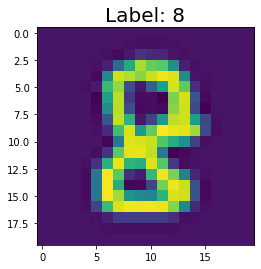

In [ ]:
while True:
    try:
        # Choose a random number
        randIdx = np.random.randint(0, X.shape[0] - 1)
        x = X[randIdx]
        # Predict
        _, _, h, _, _ = hypothesis(x, Theta1, Theta2)
        # Show result
        label = np.argmax(h)
        img = x.reshape((20, 20)).T
        plt.imshow(img)
        plt.title(f"Label: {label}", fontdict={"fontsize": 30})
        plt.show()
        time.sleep(1)
        clear_output(wait=True)
    except KeyboardInterrupt:
        print("Stopped")
        break
